In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../datasets/famcs_students.csv")

In [2]:
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_name = binary_cols[17 % 8]
print(target_name)

interest


In [3]:
df['literature'].value_counts()

literature
Да     79
Нет    48
Name: count, dtype: int64

In [4]:
feature_cols = ["stream", "sex", "os", "bad_sleep", "social", "sport", "literature"]
y = df['interest']
y = y.map({"Математика": 1,"Программирование": 0})
X = df[feature_cols]
X = pd.get_dummies(
    X,
    columns=["stream", "os", "sport", "social"],
    drop_first=False
)

yes_no_cols = ['bad_sleep', 'literature']

for col in yes_no_cols:
    X[col] = X[col].map({"Да": 1, "Нет": 0})
X['sex'] = X['sex'].map({"М": 1, "Ж": 0})

# Convert all bools to int
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# Ensure all features are float
X = X.astype(float)
X = X.values
y = y.values

In [5]:
X

array([[1., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 1.]], shape=(127, 15))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [7]:
class MostFrequentClassifier:
    def fit(self, y):
        self.pred = 0

    def predict(self, X):
        return np.full(len(X), self.pred)

In [8]:
baseline = MostFrequentClassifier()
baseline.fit(y_train)

y_pred_base = baseline.predict(X_test)
baseline_acc = (y_pred_base == y_test).mean()
baseline_acc

np.float64(0.75)

In [9]:
import numpy as np

class BernoulliNB:
    def __init__(self, alpha=1.0):  
        self.alpha = alpha  # Лапласовское сглаживание

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        # prior P(y)
        self.class_prior_ = {}
        for c in self.classes_:
            self.class_prior_[c] = np.mean(y == c)

        self.feature_prob_ = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]

            # P(x_j = 1 | y=c) = (count + alpha) / (n_class + 2*alpha)
            self.feature_prob_[idx, :] = (X_c.sum(axis=0) + self.alpha) / (X_c.shape[0] + 2 * self.alpha)

    def predict_proba(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)

        log_probs = np.zeros((n_samples, n_classes))

        for idx, c in enumerate(self.classes_):
            p = self.feature_prob_[idx]

            # log(P(y=c))
            log_prob = np.log(self.class_prior_[c])

            # log( Bernoulli likelihood )
            # x_j * log(p_j) + (1 - x_j) * log(1 - p_j)
            log_likelihood = X * np.log(p) + (1 - X) * np.log(1 - p)

            log_probs[:, idx] = log_prob + log_likelihood.sum(axis=1)

        probs = np.exp(log_probs - log_probs.max(axis=1, keepdims=True))
        probs = probs / probs.sum(axis=1, keepdims=True)

        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

In [10]:
bayes_clf = BernoulliNB()
bayes_clf.fit(X_train, y_train)
bayes_pred = bayes_clf.predict(X_test)
bayes_acc = (bayes_pred == y_test).mean()
print(bayes_acc)

0.7


In [11]:
import numpy as np
from collections import Counter

class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            # расстояния
            distances = np.linalg.norm(self.X_train - x, axis=1)
            # поисk ближайших соседей
            k_idx = distances.argsort()[:self.k]
            # метки этих соседей
            k_labels = self.y_train[k_idx]
            # Выбираем наиболее часте
            most_common = Counter(k_labels).most_common(1)[0][0]
            y_pred.append(most_common)
        return np.array(y_pred)

In [12]:
best_k = 1
best_acc = 0

for k in range(1, 11):
    knn = KNearestNeighbors(k=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    acc = (y_pred == y_val).mean()
    print(f"k={k}, accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Лучший k: {best_k}, точность: {best_acc:.4f}")

k=1, accuracy=0.5263
k=2, accuracy=0.5263
k=3, accuracy=0.6842
k=4, accuracy=0.6842
k=5, accuracy=0.7368
k=6, accuracy=0.6842
k=7, accuracy=0.7368
k=8, accuracy=0.7368
k=9, accuracy=0.7895
k=10, accuracy=0.7895
Лучший k: 9, точность: 0.7895


In [13]:
knn = KNearestNeighbors(k=9)
knn.fit(X_train, y_train)

In [14]:
import numpy as np

class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # bias
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        self.w = np.zeros(X.shape[1])

        for i in range(self.n_iter):
            z = X @ self.w
            y_pred = self.sigmoid(z)
            grad = X.T @ (y_pred - y) / len(y)
            self.w -= self.lr * grad

    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.sigmoid(X @ self.w)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [15]:
logreg = LogisticRegression(lr=0.1, n_iter=2000)
logreg.fit(X_train, y_train)

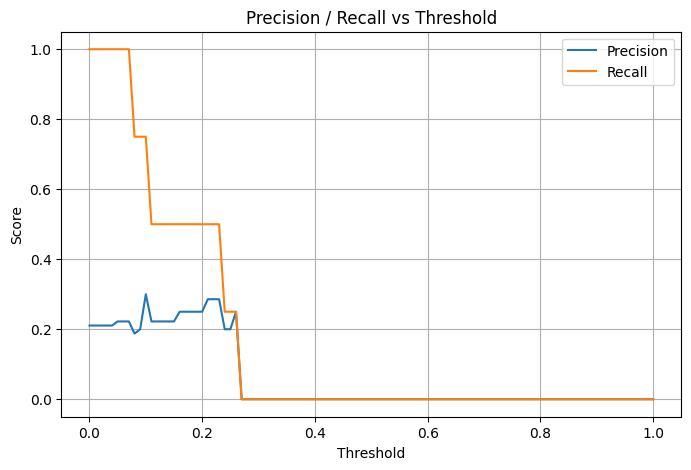

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
f1s = []

y_probs = logreg.predict_proba(X_val)

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred, zero_division=0))
    f1s.append(f1_score(y_val, y_pred, zero_division=0))

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [17]:
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Оптимальный порог по F1: {best_threshold:.2f}, F1 = {f1s[best_idx]:.4f}")

y_pred_final = (y_probs >= best_threshold).astype(int)

Оптимальный порог по F1: 0.10, F1 = 0.4286


In [18]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
        roc = roc_auc_score(y_test, y_proba)
    except:
        roc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    if roc is not None:
        print(f"ROC-AUC  : {roc:.4f}")
    else:
        print("ROC-AUC  : N/A (no predict_proba)")

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


=== Trivial ===
Accuracy : 0.7500
Precision: 0.0000
Recall   : 0.0000
ROC-AUC  : N/A (no predict_proba)


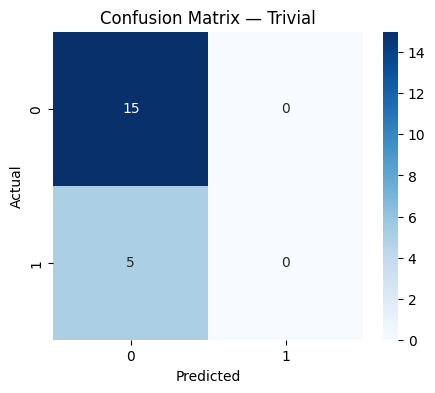


=== Naive Bayes ===
Accuracy : 0.7000
Precision: 0.0000
Recall   : 0.0000
ROC-AUC  : N/A (no predict_proba)


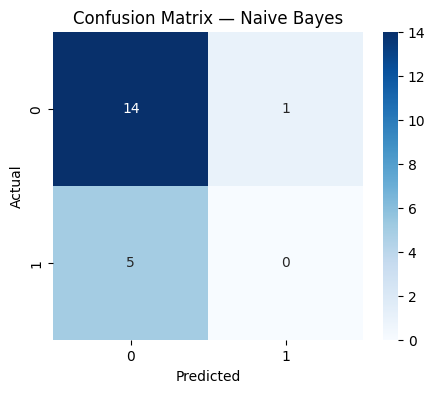


=== KNN ===
Accuracy : 0.7500
Precision: 0.0000
Recall   : 0.0000
ROC-AUC  : N/A (no predict_proba)


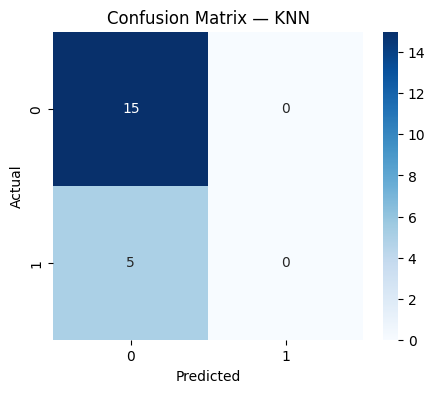


=== Logistic Regression ===
Accuracy : 0.7000
Precision: 0.0000
Recall   : 0.0000
ROC-AUC  : 0.4400


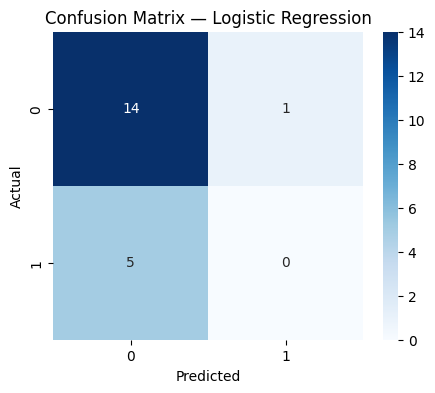

In [19]:
evaluate_model(baseline, X_test, y_test, "Trivial")

evaluate_model(bayes_clf, X_test, y_test, "Naive Bayes")

evaluate_model(knn, X_test, y_test, "KNN")

evaluate_model(logreg, X_test, y_test, "Logistic Regression")

In [20]:
y_proba = bayes_clf.predict_proba(X_test)[:,1]

In [21]:
roc_auc_score(y_test, y_proba)

0.6799999999999999